# Gaussian Filter 

## Setup

In [1]:
%pylab inline
import tensorflow as tf
from ops import *
from utils import *
from data_providers import *
slim = tf.contrib.slim
ds = tf.contrib.distributions
st = tf.contrib.bayesflow.stochastic_tensor
graph_replace = tf.contrib.graph_editor.graph_replace
import itertools
from matplotlib import animation, rc
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
params = {
    'batch_size': 200,
    'latent_dim': 256, # dimensionality of latent space
    'eps_dim': 1, # dimensionality of epsilon, used in inference net, z_phi(x, eps)
    'input_dim': 3*32*32, # dimensionality of input (also the number of unique datapoints)
    'n_layer_disc': 2, # number of hidden layers in discriminator
    'n_hidden_disc': 500, # number of hidden units in discriminator
    'n_layer_gen': 2,
    'n_hidden_gen': 500,
    'n_layer_inf': 2,
    'n_hidden_inf': 500,
    'n_layer_gan': 2,
    'n_hidden_gan': 1000,
    'n_component' : 25
}

## Create dataset

In [3]:
def standard_normal(shape, **kwargs):
    """Create a standard Normal StochasticTensor."""
    return st.StochasticTensor(
        ds.MultivariateNormalDiag(mu=tf.zeros(shape), diag_stdev=tf.ones(shape), **kwargs))


In [4]:
def conv_out_size_same(size, stride):
    return int(math.ceil(float(size) / float(stride)))

# def inference_network(x, latent_dim, n_layer, n_hidden):
#     i_bn0 = batch_norm(name='i_bn0')
#     with slim.arg_scope([slim.conv2d, slim.fully_connected],
#                       activation_fn=tf.nn.elu,
#                       normalizer_fn=slim.batch_norm,
#                       normalizer_params={'scale': True}):
#         net = x 
#         net = slim.conv2d(net, 32, 5, stride=2)
#         net = slim.conv2d(net, 64, 5, stride=2)
#         net = slim.conv2d(net, 128, 5, padding='VALID')
#         net = slim.flatten(net)
#         params = slim.fully_connected(net, latent_dim * 2, activation_fn=None, scope="q_z")
        
#         loc = params[:, :latent_dim]
#         scale = params[:, latent_dim:]
#         z = st.StochasticTensor(ds.Normal(loc, tf.sqrt(tf.exp(scale)), name="p_z"))
        
#     return z, loc, scale

def inference_network(x, latent_dim, n_layer, n_hidden):
    df_dim=64
    with tf.variable_scope('inference'):
        d_bn1 = batch_norm(name='i_bn1')
        d_bn2 = batch_norm(name='i_bn2')
        d_bn3 = batch_norm(name='i_bn3')
        h0 = lrelu(conv2d(x, df_dim, name='i_h0_conv'))
        h1 = lrelu(d_bn1(conv2d(h0, df_dim*2, name='i_h1_conv')))
        h2 = lrelu(d_bn2(conv2d(h1, df_dim*4, name='i_h2_conv')))
        h3 = lrelu(d_bn3(conv2d(h2, df_dim*8, name='i_h3_conv')))
        param = linear(tf.reshape(h3, [params['batch_size'], -1]), latent_dim*2, 'i_h3_lin')
        loc = param[:, :latent_dim]
        scale = param[:, latent_dim:]
        z = st.StochasticTensor(ds.Normal(loc, tf.sqrt(tf.exp(scale)), name="p_z"))

    return z, loc, scale

def generative_network(z, input_dim, train=True,reuse=False):
    gf_dim=64
    with tf.variable_scope("generative") as scope:
        if reuse:
            scope.reuse_variables()
            
        g_bn0 = batch_norm(name='g_bn0')
        g_bn1 = batch_norm(name='g_bn1')
        g_bn2 = batch_norm(name='g_bn2')
        g_bn3 = batch_norm(name='g_bn3')
        g_bn4 = batch_norm(name='g_bn4')
        g_bn5 = batch_norm(name='g_bn5')
        
        s_h, s_w = 32, 32
        s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
        s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
        s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
        s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

        z_, h0_w, h0_b = linear(z, gf_dim*8*s_h16*s_w16, 'g_h0_lin', with_w=True)

        h0 = tf.reshape(z_, [-1, s_h16, s_w16, gf_dim * 8])
        h0 = tf.nn.relu(g_bn0(h0,train=train))

        h1, h1_w, h1_b = deconv2d(h0, [params['batch_size'], s_h8, s_w8, gf_dim*4], name='g_h1', with_w=True)
        h1 = tf.nn.relu(g_bn1(h1,train=train))

        h2, h2_w, h2_b = deconv2d(h1, [params['batch_size'], s_h4, s_w4, gf_dim*2], name='g_h2', with_w=True)
        h2 = tf.nn.relu(g_bn2(h2,train=train))

        h3, h3_w, h3_b = deconv2d(h2, [params['batch_size'], s_h2, s_w2, gf_dim*1], name='g_h3', with_w=True)
        h3 = tf.nn.relu(g_bn3(h3,train=train))

        h4, h4_w, h4_b = deconv2d(h3, [params['batch_size'], s_h, s_w, 3], name='g_h4', with_w=True)
        h4 = tf.nn.tanh(g_bn4(h4,train=train))
        
        p = slim.fully_connected(slim.flatten(h4), 2*input_dim, activation_fn=None)
        a=p[:,:input_dim]
        b=p[:,input_dim:]
        x = st.StochasticTensor(ds.Normal(a, tf.sqrt(tf.exp(b)), name="p_x"))

    return x,h4

tf.reset_default_graph()

In [5]:
tf.reset_default_graph()
data = CIFAR10DataProvider(batch_size=params['batch_size'])

x = tf.placeholder(tf.float32, [params['batch_size'] , 32,32,3 ])
y = tf.reshape(x,[params['batch_size'],params['input_dim']])

z_gan = tf.placeholder(tf.float32, [params['batch_size'] , 32,32,3 ])

z,mu,log_sigma_sq = inference_network(x, params['latent_dim'], params['n_layer_inf'], params['n_hidden_inf'])

x_bar,a = generative_network(z.value(), params['input_dim'])

def sampler_vae(input_dim):
    z = standard_normal([params['batch_size'],params['latent_dim']])
    x_bar_0,b = generative_network(z.value(), input_dim,train=False,reuse=True)
    return b






## Network definitions

In [6]:
def gan_generator(x_bar,input_dim, n_layer, n_hidden,reuse=False,train=True):
#     x_bar = tf.reshape(x_bar,[params['batch_size'] ,32,32,3])
    
    with tf.variable_scope("gan_generative") as scope:
        if reuse:
            scope.reuse_variables()
        gan_bn1 = batch_norm(name='gan_bn1')
        gan_bn2 = batch_norm(name='gan_bn2')
        gan_bn3 = batch_norm(name='gan_bn3')
        
        x_bar = slim.flatten(x_bar)
        x_bar = slim.fully_connected(x_bar, input_dim, activation_fn=tf.nn.tanh)
        x_bar = tf.reshape(x_bar,[params['batch_size'] ,32,32,3])
        
        h0 = tf.nn.tanh(conv2d(x_bar, 3, d_h=1, d_w=1, name='gan_h0_conv'))
        h0 = gan_bn3(h0,train=train)
        h1 = tf.nn.tanh(gan_bn1(conv2d(h0, 3, d_h=1, d_w=1, name='gan_h1_conv'),train=train))
        x = 2*tf.nn.tanh((gan_bn2(conv2d(h1, 3, d_h=1, d_w=1, name='gan_h2_conv'),train=train)))
        
        
#         h3 = lrelu(gan_bn3(conv2d(h2, 3, d_h=1, d_w=1, name='gan_h3_conv'),train=train))
#         print h3
#         x = tf.nn.tanh(conv2d(h3, 3, d_h=1, d_w=1, name='gan_h4_conv'))
    return x,x

# def gan_generator(x_bar,input_dim, n_layer, n_hidden,reuse=False,train=True):
#     x_bar = slim.flatten(x_bar)
#     with tf.variable_scope("gan_generative") as scope:
#         if reuse:
#             scope.reuse_variables()
#         h = slim.fully_connected(x_bar, n_hidden, activation_fn=tf.nn.relu)
#         h = slim.fully_connected(h, n_hidden, activation_fn=tf.nn.relu)
#         x = slim.fully_connected(h, input_dim, activation_fn=None)
#         x = tf.reshape(x,[params['batch_size'] ,32,32,3])
#     return x,x

def discriminator(x):
    df_dim=64
    with tf.variable_scope('discriminator'):
        d_bn1 = batch_norm(name='d_bn1')
        d_bn2 = batch_norm(name='d_bn2')
        d_bn3 = batch_norm(name='d_bn3')
        h0 = lrelu(conv2d(x, df_dim, name='d_h0_conv'))
        h1 = lrelu(d_bn1(conv2d(h0, df_dim*2, name='d_h1_conv')))
        h2 = lrelu(d_bn2(conv2d(h1, df_dim*4, name='d_h2_conv')))
        h3 = lrelu(d_bn3(conv2d(h2, df_dim*8, name='d_h3_conv')))
        h4 = linear(tf.reshape(h3, [params['batch_size'], -1]), 1, 'd_h3_lin')

    return h4

def sampler(input_dim):
    z = standard_normal([params['batch_size'],params['latent_dim']])
    x_bar_0,b = generative_network(z.value(), input_dim,train=False,reuse=True)
    return tf.nn.tanh(1*gan_generator(b,input_dim, params['n_layer_gan'],
                                      params['n_hidden_gan'],train=False,reuse=True)[0] + b)

## Construct model and training ops

In [7]:

# z = standard_normal([params['batch_size'],params['latent_dim']]).value()
x_gan = tf.nn.tanh(1*gan_generator(a,params['input_dim'], params['n_layer_gan'], params['n_hidden_gan'])[0] + a)

log_d_prior = discriminator(x)
log_d_posterior = graph_replace(log_d_prior, {x: x_gan})

disc_loss = 1*tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=log_d_posterior, labels=tf.ones_like(log_d_posterior)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=log_d_prior, labels=tf.zeros_like(log_d_prior)))
                         
gan_loss =tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=log_d_posterior,labels=tf.zeros_like(log_d_posterior)))

latent_loss = -0.5 * tf.reduce_sum(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), 1)

kld = -0.5 * tf.reduce_mean(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), 0)

rec_loss = tf.reduce_sum(tf.square(y-(slim.flatten(a))),1)

cost = tf.reduce_mean(latent_loss+rec_loss)

x_sample_vae = sampler_vae(params['input_dim'])
x_sample = sampler(params['input_dim'])

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "gan_generative")
opt_vae = tf.train.AdamOptimizer(0.0005, beta1=.5)
opt = tf.train.AdamOptimizer(0.0005, beta1=.5)

train_vae_op =  opt_vae.minimize(cost, var_list=qvars + pvars)
train_gan_op =  opt.minimize(gan_loss, var_list=gvars + qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars)

INFO:tensorflow:Copying op: discriminator/d_h0_conv/Conv2D
INFO:tensorflow:Copying op: discriminator/d_h0_conv/BiasAdd
INFO:tensorflow:Copying op: discriminator/d_h0_conv/Reshape
INFO:tensorflow:Copying op: discriminator/mul
INFO:tensorflow:Copying op: discriminator/Maximum
INFO:tensorflow:Copying op: discriminator/d_h1_conv/Conv2D
INFO:tensorflow:Copying op: discriminator/d_h1_conv/BiasAdd
INFO:tensorflow:Copying op: discriminator/d_h1_conv/Reshape
INFO:tensorflow:Copying op: discriminator/d_bn1_1/batchnorm/mul_1
INFO:tensorflow:Copying op: discriminator/d_bn1_1/moments/sufficient_statistics/SquaredDifference
INFO:tensorflow:Copying op: discriminator/d_bn1_1/moments/Mean
INFO:tensorflow:Copying op: discriminator/d_bn1_1/moments/sufficient_statistics/Sub
INFO:tensorflow:Copying op: discriminator/d_bn1_1/moments/sufficient_statistics/mean_ss
INFO:tensorflow:Copying op: discriminator/d_bn1_1/batchnorm/add_1
INFO:tensorflow:Copying op: discriminator/d_bn1_1/moments/sufficient_statistics/v

In [8]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train model

In [9]:
from tqdm import tqdm
import collections
fs = []

batch_idxs = data.num_batches

for epoch in tqdm(xrange(100)):
    data.new_epoch()
    samples = np.zeros((0, 32, 32, 3), dtype=np.float32)
    for i in xrange(0, batch_idxs):
        batch,_=data.next()
        
        c, _ = sess.run([[cost],train_vae_op], feed_dict = {x: batch})
        if np.isnan(c[0]):
            print c[0], 'terminating training' 
            sys.exit()
    fs.append(c[0])
    generated_samples = sess.run([x_sample_vae], feed_dict = {x: batch})
    generated_samples=np.squeeze(np.array(generated_samples))
    samples = np.vstack((samples, generated_samples))
    image_frame_dim = int(math.ceil(64 ** .5))
    save_images(samples[:64], [image_frame_dim, image_frame_dim], 
                ('%s_%s.png') % ('./pics_full/vae/sample', str(epoch))) 
    
kl = sess.run(kld, feed_dict = {x: batch})

100%|██████████| 100/100 [29:06<00:00, 17.60s/it]


<Container object of 256 artists>

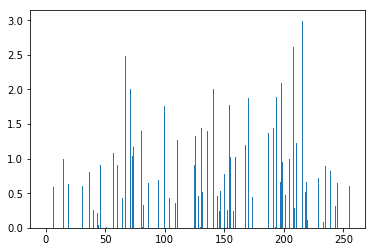

In [10]:
plt.bar(range(len(kl)),kl)

In [11]:
from tqdm import tqdm
import collections
fs = []

batch_idxs = data.num_batches

for epoch in tqdm(xrange(50)):
    data.new_epoch()
    samples = np.zeros((0, 32, 32, 3), dtype=np.float32)
    for i in xrange(0, batch_idxs):
        try:
            batch,_=data.next()
            batch_1,_=data.next()
        except:
            break

    
        c, _ = sess.run([[gan_loss, disc_loss],[train_gan_op, train_disc_op]]
                        , feed_dict = {x: batch,z_gan: batch_1})
        if np.isnan(c[0]) or np.isnan(c[1]):
            sys.exit()
    fs.append(c[0])
        
    generated_samples = sess.run([x_sample], feed_dict = {x: batch,z_gan: batch_1})
    generated_samples=np.squeeze(np.array(generated_samples))
    samples = np.vstack((samples, generated_samples))
    image_frame_dim = int(math.ceil(64 ** .5))
    save_images(samples[:64], [image_frame_dim, image_frame_dim], 
                ('%s_%s.png') % ('./pics_full/vae/sample_gan', str(epoch))) 
    
# plt.bar(len(fs),fs)

100%|██████████| 50/50 [18:11<00:00, 21.81s/it]
